# Building Micrograd - Part 2

From this lecture: https://www.youtube.com/watch?v=VMj-3S1tku0

Micrograd is a neural network library that uses the neural network system to build mathematical functions, and can be used to find the derivatives of variables relative to wher ethe backpropagation was formed. You can find more out abotu micrograd here: https://github.com/karpathy/micrograd

In [1]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

## Value object

In [2]:
class Value:

    def __init__(self, data, _children=(), _op='', label='') -> None:
        self.data = data
        self._prev = set(_children) 
        self._op = _op 
        self.label = label
        self.grad = 0.0 
        self._backward = lambda: None 

    def __repr__(self) -> str:
        return f"Value(data={self.data})" 
    
    def __add__(self, other):
        # Ensure that other is a Value, so we can do a + 1
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+') 
        def _backward():
            self.grad += 1.0 * out.grad 
            other.grad += 1.0 * out.grad
        out._backward = _backward
        return out
    
    # At present, a + 2 works but not 2 + a as integers don't have Value in their addition method
    # So we can use the __radd__ method to handle this, as when the integer's add fails,
    def __radd__(self, other):
        return self.__add__(other)
    
    def __sub__(self, other): # self - other
        return self + (-other)
    
    def __neg__(self): # -self
        return self * -1
    
    def __mul__(self, other):
        # Ensure that other is a Value, so we can do a * 1
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*') 
        def _backward():
            self.grad += other.data * out.grad
            other.grad += self.data * out.grad
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "Only supporting int/float for now"
        out = Value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * self.data**(other-1) * out.grad
        out._backward = _backward
        return out
    
    # At present, a * 2 works but not 2 * a as integers don't have Value in their multiplication method
    # So we can use the __rmul__ method to handle this, as when the integer's mul fails,
    # it will try to call the Value's rmul method instead
    def __rmul__(self, other):
        return self.__mul__(other)
    
    def __truediv__(self, other): # self / other
        return self * other**-1
    
    def tanh(self):
        n = self.data
        t = (math.exp(2*n) - 1)/(math.exp(2*n) + 1)
        out = Value(t, (self,), 'tanh')
        def _backward():
            self.grad += (1-t**2) * out.grad
        out._backward = _backward
        return out
    
    def exp(self):
        out = Value(math.exp(self.data), (self,), 'exp')
        # The derivative of e^x is e^x (fun!)
        def _backward():
            self.grad += out.data * out.grad # out.data is e^x
        out._backward = _backward
        return out
    
    # Our backwards pass
    def backward(self):
        self.grad = 1
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)
        for node in reversed(topo):
            node._backward()

In [3]:
# Tests for our new implementation
a = Value(2.0)
print(f'{a * 2=}')
print(f'{2 * a=}')
print(f'{(a.exp()).data=}')

a * 2=Value(data=4.0)
2 * a=Value(data=4.0)
(a.exp()).data=7.38905609893065


In [4]:
# Let's add in some visualisation
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{%s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [5]:
# Reset the data
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
# Add together
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
# add bias
n = x1w1x2w2 + b; n.label = 'n'
# activation
o = n.tanh(); o.label = 'o'

o.backward()

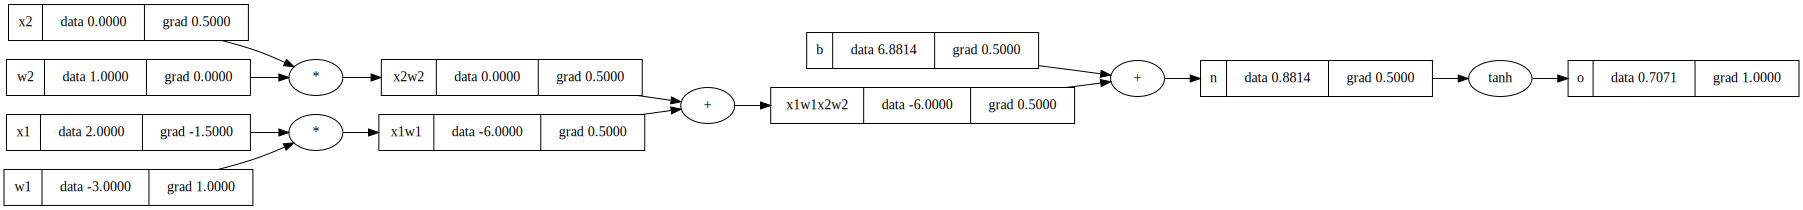

In [6]:
draw_dot(o)

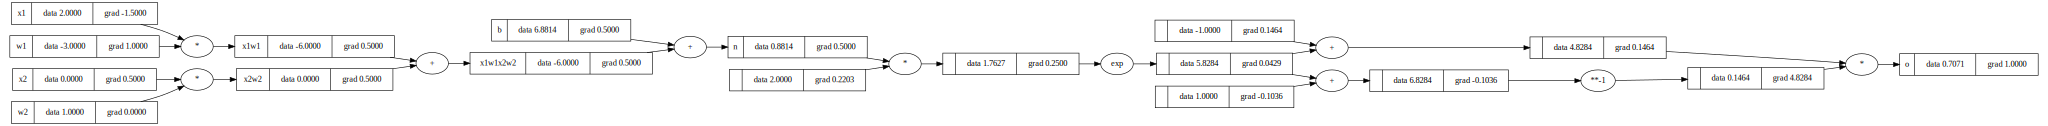

In [7]:
# Reset the data
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1, w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')

x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
# Add together
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1w1x2w2'
# add bias
n = x1w1x2w2 + b; n.label = 'n'
# let's break down the tanh
e = (2*n).exp()
o = (e-1)/(e+1)
# ---
o.label = 'o'
o.backward()
draw_dot(o)

Looks like expanding the tanh was correct, as our backward pass, while expanded, produced the same gradient sfor the common nodes between the prior method and this one.

## PyTorch API

Let's replicate htis in PyTorch API

In [8]:
import torch

We are just using scalar tensors. We would usually use far more complicated tensors.

In [9]:
# Casting to double as default in pytorch is float64
x1 = torch.Tensor([2.0]).double()                ; x1.requires_grad = True # let torch knopw that we want to calculate the gradient
x2 = torch.Tensor([0.0]).double()                ; x2.requires_grad = True # They are set to false by default due to memory constraints
w1 = torch.Tensor([-3.0]).double()               ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double()                ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double()  ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item()) # .item() to get the value of a tensor
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


/home/ed/anaconda3/envs/micrograd_3_12/lib/python3.12/site-packages/torch/autograd/graph.py:768: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


PyTorch agrees with our gradients!

## Build out a neural network

In [14]:
import random

class Neuron:
    def __init__(self, nin):
        self.w = [Value(random.uniform(-1, 1)) for _ in range(nin)]
        self.b = Value(random.uniform(-1, 1))

    def __call__(self, x):
        # w * x + b
        # zip takes two iterables and returns an iterator of tuples
        # act = sum(wi*xi for wi, xi in zip(self.w, x)) + self.b, but a more efficient way is
        act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b) # as the second argument of sum is the starting point
        # activation function
        out = act.tanh()
        return out

# We can now forward a single neuron.

class Layer:
    #  a layer is a collection of neurons, here a list
    def __init__(self, n_in, n_out):
        self.neurons = [Neuron(n_in) for _ in range(n_out)]

    def __call__(self, x):
        return [n(x) for n in self.neurons]
    

class MLP:
    def __init__(self, n_in, n_outs):
        sz = [n_in] + n_outs # this is the size of the network
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(sz)-1)] # create the layers

    def __call__(self, x):
        # we just call them sequentially
        for layer in self.layers:
            x = layer(x)
        return x
    
x = [2.0, 3.0]
n = Neuron(2)
print(n(x))


x = [2.0, 3.0]
n = Layer(2, 3)
print(n(x))

Value(data=0.2480677772372529)
[Value(data=0.017822824099942482), Value(data=-0.2163517663947759), Value(data=-0.9613156343986077)]
